In [54]:
%run .\word_embedding.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GANAPRIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GANAPRIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GANAPRIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\GANAPRIYA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


127
[[    0     0     0 ... 10654  7659 39156]
 [    0     0     0 ...     0  5961 13723]
 [    0     0     0 ...     0     0  8377]
 ...
 [    0     0     0 ...     0     0 23799]
 [    0     0     0 ...     0  6224 23799]
 [    0     0     0 ...     0  6224  3646]]


In [55]:
import numpy as np
import pickle,itertools
import matplotlib.pyplot as plt

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras import layers

In [56]:
maxlen

127

In [57]:
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding,Dropout, LSTM, Bidirectional,Dense, Input, Flatten
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [67]:
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim = MAX_NB_WORDS,
              output_dim = EMBEDDING_DIM,
              input_length = maxlen,
             ))
    for i in range(hp.Int('num_layers',1 , 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=256,
                                            step=32),
                               return_sequences=True,dropout=0.0, recurrent_dropout=0.0))
    model.add(LSTM(units=hp.Int('lstm',
                                            min_value=32,
                                            max_value=256,
                                            step=32),dropout=0.3, recurrent_dropout=0.0))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [68]:
tuner=RandomSearch(
                          build_model,
                          objective='val_loss',
                          max_trials=3,
                          executions_per_trial=1,
                          overwrite=True,
                          directory='output',
                          project_name="sentiment_analytics")

In [69]:
tuner.search_space_summary()

Search space summary
Default search space size: 0


In [70]:
tuner.search(x_train, y_train,
             epochs=40,
             validation_data=(x_val, y_val))

Trial 1 Complete [00h 16m 23s]
val_loss: 1.2734133005142212

Best val_loss So Far: 1.2734133005142212
Total elapsed time: 00h 16m 23s
INFO:tensorflow:Oracle triggered exit


In [72]:
tuner.results_summary()

Results summary
Results in output\sentiment_analytics
Showing 10 best trials
Trial summary
Hyperparameters:
default configuration
Score: 1.2734133005142212


In [73]:
model=tuner.get_best_models(num_models=1)[0]

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 100)          4000000   
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 4,080,905
Trainable params: 4,080,905
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.save('sentiment_analysis1.h5')

In [151]:
# Sequential

model=Sequential()
model.add(Embedding(input_dim = MAX_NB_WORDS,
              output_dim = EMBEDDING_DIM,
              input_length = maxlen
#               weights = [embedding_matrix],
#               trainable = False
             ))
model.add(Bidirectional(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))) # 1 lstm layer with 100 neurons
model.add(Bidirectional(LSTM(224,return_sequences=True,dropout=0.0, recurrent_dropout=0.0)))
model.add(Bidirectional(LSTM(32,dropout=0.3, recurrent_dropout=0.0)))
model.add(Dense(5, activation='softmax'))

In [38]:
# Functional API

sequence_input =Input(shape=(maxlen,), dtype='int32')
# static channel

# non-static channel
embedding_layer_train = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
#                             weights=[embedding_matrix],
                            input_length=maxlen,
#                             trainable=True
                                 )
embedded_sequences_train = embedding_layer_train(sequence_input)
lstm1 = Bidirectional(LSTM(100,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))(embedded_sequences_train)
lstm2 = Bidirectional(LSTM(200,return_sequences=True,dropout=0.0, recurrent_dropout=0.0))(lstm1)
lstm3 = Bidirectional(LSTM(200,dropout=0.3, recurrent_dropout=0.0))(lstm2)
preds = Dense(5, activation='softmax')(lstm3)
model = Model(sequence_input, preds)

In [152]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [153]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 127, 200)          8000000   
                                                                 
 bidirectional (Bidirectiona  (None, 127, 448)         761600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 127, 448)         1206016   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               123136    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                      

In [9]:
model.save('sentiment_analysis1.h5')

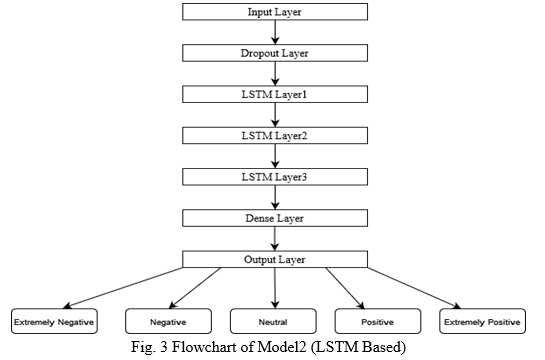

In [1]:
model = load_model("sentiment_analysis_model.h5")

NameError: name 'load_model' is not defined

In [136]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 127, 200)          8000000   
                                                                 
 bidirectional (Bidirectiona  (None, 127, 448)         761600    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 127, 448)         1206016   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               123136    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                        

In [154]:
# from keras import callbacks
# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

# model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
#           epochs=100, batch_size=128, callbacks =[earlystopping])

model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=128)

Epoch 1/100
350/350 [==============================] - 123s 279ms/step - loss: 1.4141 - accuracy: 0.3670 - val_loss: 1.3247 - val_accuracy: 0.4257
Epoch 2/100
350/350 [==============================] - 97s 277ms/step - loss: 1.2137 - accuracy: 0.4840 - val_loss: 1.2833 - val_accuracy: 0.4486
Epoch 3/100
350/350 [==============================] - 97s 278ms/step - loss: 1.0699 - accuracy: 0.5552 - val_loss: 1.2648 - val_accuracy: 0.4665
Epoch 4/100
350/350 [==============================] - 97s 279ms/step - loss: 0.9526 - accuracy: 0.6057 - val_loss: 1.2947 - val_accuracy: 0.4731
Epoch 5/100
350/350 [==============================] - 98s 279ms/step - loss: 0.8553 - accuracy: 0.6439 - val_loss: 1.3211 - val_accuracy: 0.4801
Epoch 6/100
350/350 [==============================] - 97s 279ms/step - loss: 0.7774 - accuracy: 0.6693 - val_loss: 1.4022 - val_accuracy: 0.4845
Epoch 7/100
350/350 [==============================] - 97s 278ms/step - loss: 0.7128 - accuracy: 0.6888 - val_loss: 1.4463 

Epoch 57/100
350/350 [==============================] - 89s 253ms/step - loss: 0.2237 - accuracy: 0.8687 - val_loss: 3.4739 - val_accuracy: 0.5181
Epoch 58/100
350/350 [==============================] - 89s 254ms/step - loss: 0.2357 - accuracy: 0.8647 - val_loss: 3.3067 - val_accuracy: 0.5177
Epoch 59/100
350/350 [==============================] - 89s 254ms/step - loss: 0.2393 - accuracy: 0.8657 - val_loss: 3.3306 - val_accuracy: 0.5202
Epoch 60/100
350/350 [==============================] - 89s 254ms/step - loss: 0.2326 - accuracy: 0.8660 - val_loss: 3.3545 - val_accuracy: 0.5215
Epoch 61/100
350/350 [==============================] - 89s 253ms/step - loss: 0.2269 - accuracy: 0.8683 - val_loss: 3.4531 - val_accuracy: 0.5134
Epoch 62/100
350/350 [==============================] - 89s 254ms/step - loss: 0.2251 - accuracy: 0.8682 - val_loss: 3.3250 - val_accuracy: 0.5184
Epoch 63/100
350/350 [==============================] - 89s 254ms/step - loss: 0.2287 - accuracy: 0.8669 - val_loss: 3

In [159]:
with open('log.pickle', 'wb') as f:
    pickle.dump(model_log.history, f, pickle.HIGHEST_PROTOCOL)

In [160]:
model.save('sentiment_analysis_model.h5')

In [112]:
classes = ["Extremely happy", "happy", "neutral", "sad","anger"]

In [113]:
Y_test = np.argmax(y_val, axis=1) # Convert one-hot to index
y_pred = model.predict(x_val)
y_pred_class = np.argmax(y_pred,axis=1)
cnf_matrix = confusion_matrix(Y_test, y_pred_class)
confusion_matrix(Y_test, y_pred_class)

689/689 [==============================] - 26s 33ms/step


array([[ 912, 2508,  414,  316,  253],
       [1620, 2296,  194,  155,  124],
       [ 376,  394, 3038,  308,  376],
       [ 281,  277,  279, 2567,  973],
       [ 228,  280,  314, 1066, 2495]], dtype=int64)

In [114]:
print(classification_report(Y_test, y_pred_class, target_names=classes))

                 precision    recall  f1-score   support

Extremely happy       0.27      0.21      0.23      4403
          happy       0.40      0.52      0.45      4389
        neutral       0.72      0.68      0.70      4492
            sad       0.58      0.59      0.58      4377
          anger       0.59      0.57      0.58      4383

       accuracy                           0.51     22044
      macro avg       0.51      0.51      0.51     22044
   weighted avg       0.51      0.51      0.51     22044



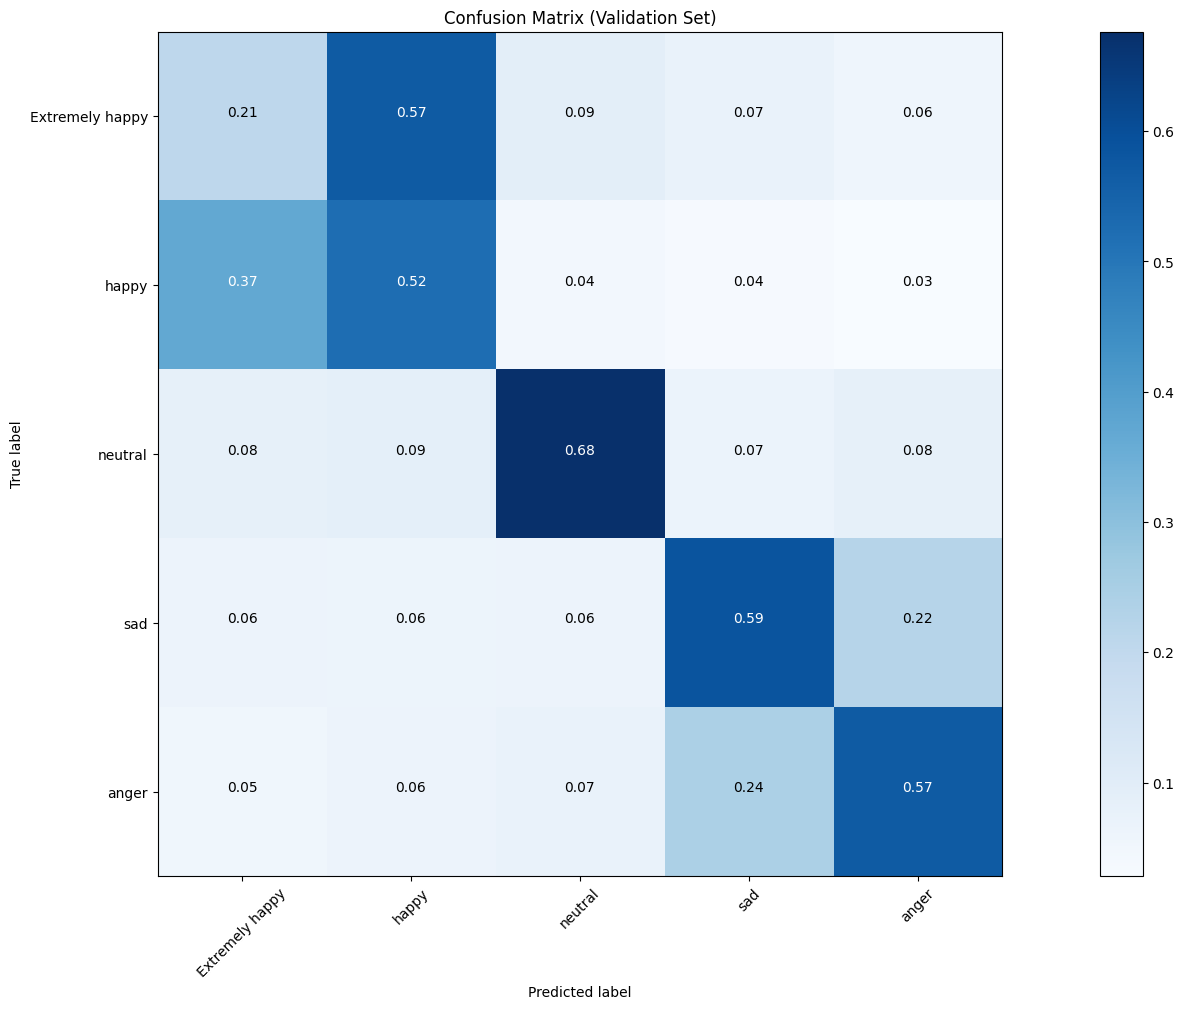

In [115]:
def plot_confusion_matrix(cm, labels,
                          normalize=True,
                          title='Confusion Matrix (Validation Set)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, labels=classes)


In [116]:
x_train

array([[    0,     0,     0, ...,  7659, 28419, 30200],
       [    0,     0,     0, ..., 17077, 35348,  2699],
       [    0,     0,     0, ...,  8772, 17155, 22687],
       ...,
       [    0,     0,     0, ..., 33655, 29051, 15668],
       [    0,     0,     0, ...,  5215, 24499, 14205],
       [    0,     0,     0, ..., 39952, 37017, 24892]])

In [166]:
text = ["anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da",
        "It bad fuck worst",
        "I am awesome",
        "I am good",
        "What a burden. Abit of a fail lunch with Dan",
        "dges our dissertation is due and the strike is coming worried",
        "angry",
       'I am not good','I am bad','I am not bad','I am worried','I am not worried','I am good','no good','no bad']



In [167]:
corpus_test = []
for i in range(0, len(text)):
    print(i)
    review = text[i].split()
    review= [word for word in review if not word.startswith('@') ]
    review = ' '.join(review)
    
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    
    review= str(TextBlob(review).correct())
    
    review = word_tokenize(review)
    final=[]
    for word in review:
         if word.endswith("'t"):
            word='not'
         if word not in stopwords:
#             final.append(word)
#          else:
#             final.append(ps.stem(word))
            final.append(wl.lemmatize(word,pos='v'))
    
    final = ' '.join(final)
    print(text[i])
    print(final)
    corpus_test.append(final)

0
anyways so my teacher was worried that i was gonna cry during the presentation but i didn t at the end of the da
anyway teacher worry donna cry during presentation end da
1
It bad fuck worst
bad fuck worst
2
I am awesome
awesome
3
I am good
good
4
What a burden. Abit of a fail lunch with Dan
burden bite fail lunch dan
5
dges our dissertation is due and the strike is coming worried
dissertation due strike come worry
6
angry
angry
7
I am not good
not good
8
I am bad
bad
9
I am not bad
not bad
10
I am worried
worry
11
I am not worried
not worry
12
I am good
good
13
no good
no good
14
no bad
no bad


In [139]:

# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

# sequences_test = tokenizer.texts_to_sequences(corpus_test)

# data_test = pad_sequences(sequences_test, padding='post', maxlen=maxlen)
# y_prob = model.predict(data_test)
# print( np.argmax(y_prob[2]))
# for n, prediction in enumerate(y_prob):
#     pred = np.argmax(y_prob,axis=1)[n]
#     print(text[n],"\nPrediction:",classes[pred],"\n")
# print(tokenizer.sequences_to_texts(data_test))

In [168]:
onehot_test=[one_hot(words,MAX_NB_WORDS)for words in corpus_test] 

In [169]:
embedded_docs=pad_sequences(onehot_test,padding='pre',maxlen=maxlen)
print(embedded_docs)

[[    0     0     0 ... 20984 24948 34636]
 [    0     0     0 ...  3646 22701 17746]
 [    0     0     0 ...     0     0 23355]
 ...
 [    0     0     0 ...     0     0 23799]
 [    0     0     0 ...     0  6224 23799]
 [    0     0     0 ...     0  6224  3646]]


In [170]:
data_test=np.array(embedded_docs)
data_test

array([[    0,     0,     0, ..., 20984, 24948, 34636],
       [    0,     0,     0, ...,  3646, 22701, 17746],
       [    0,     0,     0, ...,     0,     0, 23355],
       ...,
       [    0,     0,     0, ...,     0,     0, 23799],
       [    0,     0,     0, ...,     0,  6224, 23799],
       [    0,     0,     0, ...,     0,  6224,  3646]])

In [161]:
with open('log.pickle', 'rb') as f:
    log = pickle.load(f)

In [ ]:
y_pred = model.predict(data_test)
y_pred_class = np.argmax(y_pred,axis=1)
np.argmax(y_pred,axis=1)
# for n, prediction in enumerate(y_pred):
#     pred = np.argmax(y_prob,axis=1)[n]
#     print(text[n],"\nPrediction:",classes[pred],"\n")


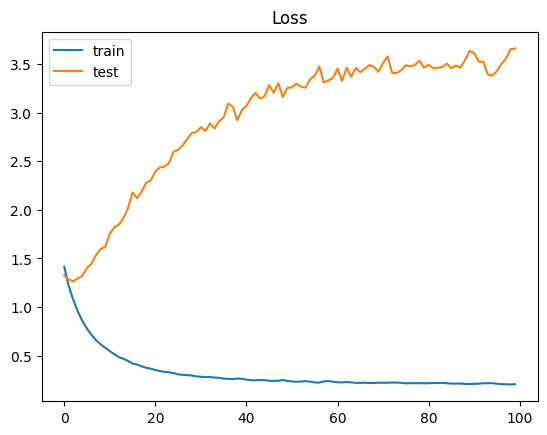

In [162]:
plt.title('Loss')
plt.plot(log['loss'], label='train')
plt.plot(log['val_loss'], label='test')
plt.legend()
plt.show();

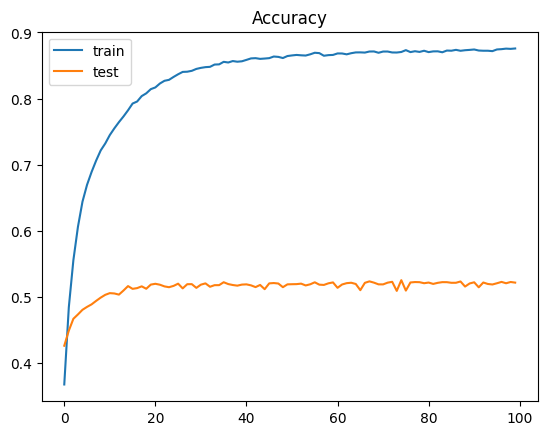

In [163]:
plt.title('Accuracy')
plt.plot(log['accuracy'], label='train')
plt.plot(log['val_accuracy'], label='test')
plt.legend()
plt.show();

In [2]:
# plt.title('Accuracy')
# plt.plot(model_log.history['accuracy'], label='train')
# plt.plot(model_log.history['val_accuracy'], label='test')
# plt.legend()
# plt.show();